In [1]:
% some housekeeping stuff
%register_graphics_toolkit ("gnuplot");
%available_graphics_toolkits ();
%graphics_toolkit ("gnuplot")
%graphics_toolkit ("notebook")
graphics_toolkit ("plotly")
clear
% load packages
warning off
pkg load statistics
% end of housekeeping

# Linear Regresion (reminder)

 - linear models have the form
 
 $$ y= \beta_1 X_1 + \beta_2 X_2 + ... + \beta_n X_n$$
 
 - it is linear in the parameters (not necessarily in $X$)  
 - X can be transformation of the independent variable ($x$).  We did an example of $x^2$, but could be $\sin(x)$ or $\log(x)$ or whatever.  ($X$ can't be a function of $x$ and $y$ though, the only variable term in the expression for each $X$ must be $x$)
 - nonlinear models are everthing else
 - let's do an example with the first order decay equation
 
 $$ N = N_0 e^{-kt} $$
 
  - let's assume an initial concentration of 0.01 M and a rate constant of 0.4 s$^{-1}$

In [2]:
%plot -s 600,600 -f 'svg'

% define the variables and constants
N0=0.01; k=0.4; t=0:1:10;

% define the function.  remember the anonymous function from Lecture 1?
firstorderdecay = @(t,N0,k) (N0.*exp(-k*t));

%calculate N as a function of time
N=firstorderdecay(t,N0,k); Nnoerror=N;

%plot it
plot(t,N,'ko')

%let's add some noise
err=0.02*max(N);
N=N+err*randn(1,length(N));

%plot with error
plot(t,N,'ko',t,Nnoerror,'k-')
xlabel('time'); ylabel('Signal')


### nonlinear optimization in matlab/octave

 - fundamentally nonlinear regression is searching for the minimum to the error furnction, defind as the sum of squares of the error
 - fminsearch is the command in Octave and Matlab to do this.  you will see an example below.
  - fminsearch is based on the simplex algorithm (seperate lecture if we want to "go there").  Simplex has the advantage of not needing a gradient calculation and will even work for discontinuous functions
  - with optimization toolbox in Matlab (and maybe in Octave?) there are other options for this search.  Gradient methods, constrained methods, ...
  - first let's look at the error (SSE) surface

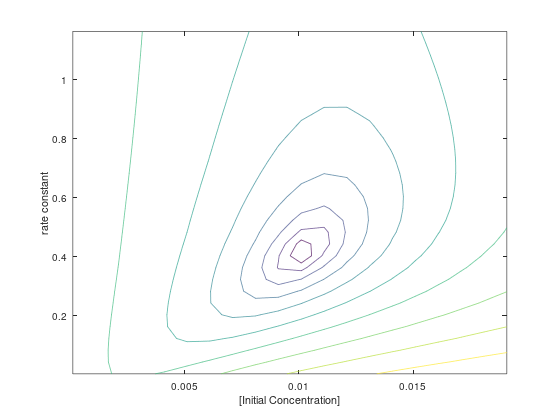

In [3]:
%plot -s 600,600 -f 'svg'

graphics_toolkit ("notebook")

% make parameter ranges based on % of the parameter values
% you could "hard code" this with specific numbers but using 
% percent let's you span a good range I think.

N0range=0.01*N0:0.1*N0:2*N0;
krange=0.01*k:0.1*k:3*k;

% now a loop to calcualte the error

for i=1:length(N0range)
    for j=1:length(krange)
        model=firstorderdecay(t,N0range(i),krange(j)); 
        SSE(j,i)=sum((model-N).^2);
    end
end

% and contour it.  try also contour as SSE and you will see
% how log of the error helps
% and also look at the mesh

contour(N0range,krange,log10(SSE),10)
%mesh(N0range,krange,log10(SSE))
xlabel('[Initial Concentration]'); ylabel('rate constant')


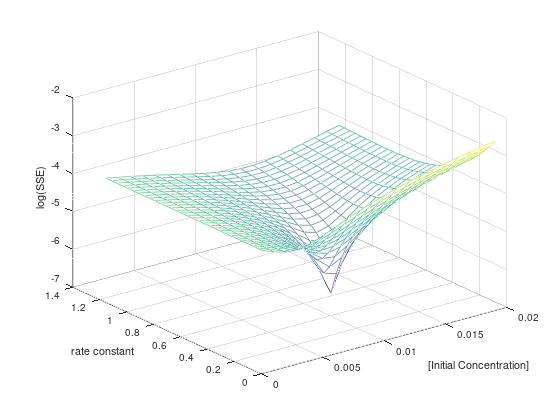

In [9]:
mesh(N0range,krange,log10(SSE))
xlabel('[Initial Concentration]'); ylabel('rate constant'); zlabel('log(SSE)')

In [4]:
% so to optmize it we need to first define the error function
% this is what will get minimized

graphics_toolkit ("plotly")

% initial guess

errorfunction = @(p,N,t) (log10(sum((N-p(1).*exp(-p(2)*t)).^2)));

ktst=0.3; N0tst=0.01; ptst=[N0tst ktst];

err=errorfunction(ptst,N,t)

Ntst=firstorderdecay(t,N0tst,ktst); 

plot(t,N,'ko',t,Ntst,'k-'); 
xlabel('time'); ylabel('Signal')


err = -5.1398


In [5]:
% now best fit

options = optimset('Display','iter','TolFun',1e-4,'TolX',1e-4);

pbest=fminsearch(@(p) errorfunction(p,N,t),ptst,options)

Nbst=firstorderdecay(t,pbest(1),pbest(2)); 

plot(t,N,'ko',t,Nbst,'b-')
xlabel('time'); ylabel('Signal')



f(x0) = -5.1398e+00
Iter.  1,  how = initial  , nf =   3,  f = -5.1398e+00  (0.0%)
Iter.  2,  how = shrink,    nf =   7,  f = -5.1398e+00  (0.0%)
Iter.  3,  how = shrink,    nf =  11,  f = -5.1398e+00  (0.0%)
Iter.  4,  how = shrink,    nf =  15,  f = -5.1398e+00  (0.0%)
Iter.  5,  how = shrink,    nf =  19,  f = -5.1398e+00  (0.0%)
Iter.  6,  how = shrink,    nf =  23,  f = -5.1398e+00  (0.0%)
Iter.  7,  how = contract,  nf =  25,  f = -5.1398e+00  (0.0%)
Iter.  8,  how = contract,  nf =  27,  f = -5.1398e+00  (0.0%)
Iter.  9,  how = shrink,    nf =  31,  f = -5.1398e+00  (0.0%)
Iter. 10,  how = contract,  nf =  33,  f = -5.1584e+00  (0.4%)
Iter. 11,  how = contract,  nf =  35,  f = -5.2205e+00  (1.2%)
Iter. 12,  how = contract,  nf =  37,  f = -5.2973e+00  (1.5%)
Iter. 13,  how = contract,  nf =  39,  f = -5.3191e+00  (0.4%)
Iter. 14,  how = contract,  nf =  41,  f = -5.3675e+00  (0.9%)
Iter. 15,  how = reflect,   nf =  42,  f = -5.3675e+00  (0.0%)
Iter. 16,  how = contract,  nf =  4

pbest,1,2
1,0.0101788,0.417871


In [6]:
% plot the residuals

plot(t,N-Nbst,'ko',t,zeros(size(N)),'k-')
xlabel('time'); ylabel('Residuals')

### now monte carlo analysis for parameter uncertainty estimation

to estimate uncertainty in the parameters just simulate 1000 datasets and fit them all.  Like we did in Lecture 3 (but we did it with a linear example that time to illustrate the method)

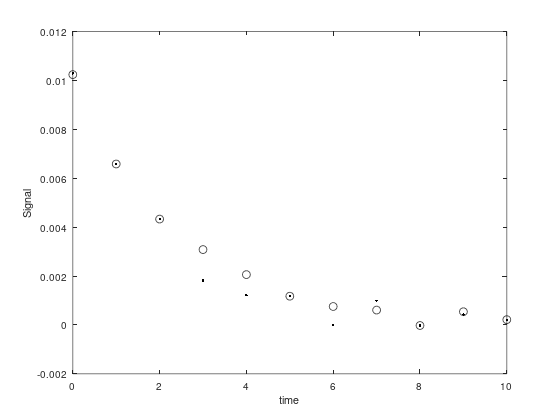

In [7]:
residuals=N-Nbst; sestimate=std(residuals);

% need to make simulated dataset

count = 1:length(N); % an integer vector with an entry in order per each point in the data

% replacing all data seems to work better

%noreplace=round(length(N)/3); % replace 1/3 of the datapoints
noreplace=round(length(N)/2); % replace 1/2 of the datapoints
%noreplace=round(length(N)/1); % replace all of the datapoints

indexreplace = randsample(count,noreplace); % pick at random wich of the 1/3 of the points to replace.

Nnew=Nbst; % initialize the simulated data just as the original data.
Nnew=N; % initialize the simulated data just as the original data.

for i=1:length(indexreplace)
    Nnew(indexreplace(i))=Nbst(indexreplace(i))+randn(1,1)*sestimate*3;
end

graphics_toolkit ("notebook")
plot(t,N,'ko',t,Nnew,'k.')
xlabel('time'); ylabel('Signal')


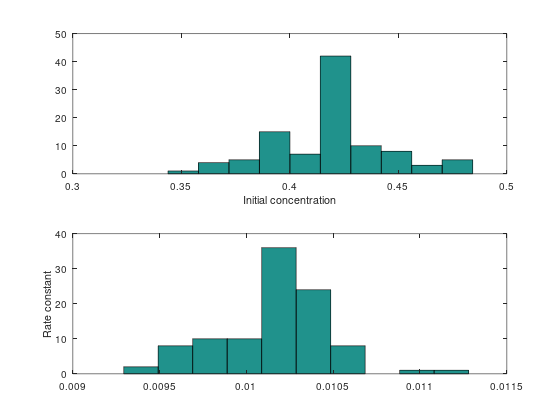

In [8]:
% monte carlo analysis

graphics_toolkit ("notebook")

%Nbst=Nnoerror; %if set that the first fit was exactly correct we get the mean value as the true values.

for j=1:100
    indexreplace = randsample(count,noreplace); % pick at random wich of the 1/3 of the points to replace
    Nnew=N; % initialize the simulated data just as the original data.

    for i=1:length(indexreplace)
        Nnew(indexreplace(i))=Nbst(indexreplace(i))+randn(1,1)*sestimate*3;
    end
    
    MCbetas(:,j)=fminsearch(@(p) errorfunction(p,Nnew,t),pbest);
    
end

MCk=MCbetas(2,:); MCN0=MCbetas(1,:);

subplot(211); 
hist(MCk,10);
xlabel('Initial concentration')

subplot(212)
hist(MCN0,10);
xlabel('Rate constant')


